## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a small portion of Haiti Tree Project (THTP) captures labeled by Cam. These are full images and represent a small portion of the dataset (hence small). This notebook is for transfer learning using a pretrained Inception v3 classifier, same as that used by Pl@ntNet.


### Dependencies

In [2]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time

from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


import requests
import json


torch.backends.cudnn.benchmark = True

Confusion matrix:


NameError: name 'cf_matx' is not defined

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://gconfusion_matrixcom/Greenstand/Tree_Species/tree/master/training)).

In [3]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.13.29.55_18.29298411961645_-73.5581...,https://treetracker-production-images.s3.eu-ce...


In [4]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data.apply(image_saver, axis=1)


0      (/home/ec2-user/SageMaker/treetracker-machine-...
1      (/home/ec2-user/SageMaker/treetracker-machine-...
2      (/home/ec2-user/SageMaker/treetracker-machine-...
3      (/home/ec2-user/SageMaker/treetracker-machine-...
4      (/home/ec2-user/SageMaker/treetracker-machine-...
                             ...                        
383    (/home/ec2-user/SageMaker/treetracker-machine-...
384    (/home/ec2-user/SageMaker/treetracker-machine-...
385    (/home/ec2-user/SageMaker/treetracker-machine-...
386    (/home/ec2-user/SageMaker/treetracker-machine-...
387    (/home/ec2-user/SageMaker/treetracker-machine-...
Length: 388, dtype: object

388  total samples
Class breakdown
{'ACACAURI': 111, 'ANACOCCI': 53, 'CATALONG': 75, 'MANGINDI': 149}
4  classes found


Text(0.5, 1.0, 'Count per class')

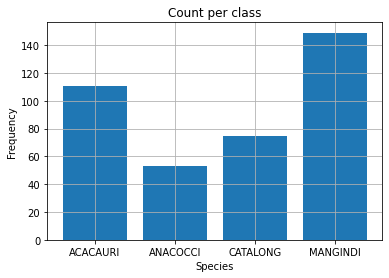

In [5]:
print (data.shape[0], " total samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [6]:
arrs = []
labels = []

# You must initialize logging, otherwise you'll not see debug output.
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((299, 299)))
            labels.append(species)
            


NameError: name 'logging' is not defined

## Visualize a few images


In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import feature
from skimage.color import rgb2gray

n_imgs = 36
idxs = np.random.choice(np.arange(0, len(arrs)), replace=False, size=n_imgs)
f, axarr = plt.subplots(6, 6, figsize=(10 ,10))
for i in range(6):
    for j in range(6):
        idx = idxs[i * 3 + j]
        # axarr[i, j].imshow(feature.canny(rgb2gray(np.array(arrs[idx]))))
        axarr[i, j].imshow(feature.canny((np.array(arrs[idx])[:, :, 1]), sigma=1.))
        axarr[i, j].set_title(labels[idx])
plt.show()
    

In [ ]:
X = np.vstack([feature.canny(rgb2gray(np.array(img))).flatten() for img in arrs])
pca = PCA(n_components=50)
X_red = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")

In [100]:
X_embedded = TSNE(n_components=2, perplexity=20.0, learning_rate=24.0, n_iter=10000).fit_transform(X_red)
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [101]:
print (tsne_result.head(5))

          x0        x1     class  Color
0 -10.435868 -4.746322  ACACAURI    0.0
1  -7.293347 -7.428767  ACACAURI    0.0
2  -3.500751 -6.763842  ACACAURI    0.0
3  -8.031733 -6.648851  ACACAURI    0.0
4  -8.131389  6.613599  ACACAURI    0.0


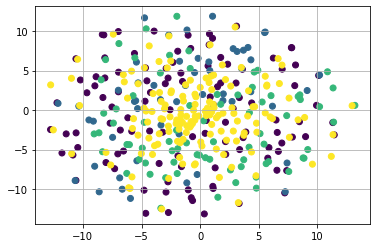

In [102]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"], label=tsne_result["class"])


In [7]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]


In [8]:
val_split = 0.3
num_epochs = 1000

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

transform = T.Compose([T.Resize(512), 
                       T.CenterCrop(299), # need center 299 pixel for Inception v3 feature extractor
                       T.RandomRotation(degrees=90),
                       T.RandomHorizontalFlip(p=0.5), 
                       T.ColorJitter(), 
                       T.ToTensor()])

tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)



In [9]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)

class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
inception = inception.to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.005)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Device:  cuda:0


In [107]:
print (data.head(5))

      class                                             imname  \
0  ACACAURI  2020.11.29.12.18.36_18.285143729299307_-73.564...   
1  ACACAURI  2020.11.29.12.18.59_18.285102993249893_-73.564...   
2  ACACAURI  2020.11.29.12.47.34_18.290133895352483_-73.557...   
3  ACACAURI  2020.11.29.12.50.51_18.29083981923759_-73.5582...   
4  ACACAURI  2020.11.29.13.29.55_18.29298411961645_-73.5581...   

                                                 url  
0  https://treetracker-production-images.s3.eu-ce...  
1  https://treetracker-production-images.s3.eu-ce...  
2  https://treetracker-production-images.s3.eu-ce...  
3  https://treetracker-production-images.s3.eu-ce...  
4  https://treetracker-production-images.s3.eu-ce...  


In [121]:
for epoch in range(num_epochs):
    running_loss = 0
    start = time.time()
    tr_acc_sum = 0
    tr_samples = 0
    n_tr_batches = 0
    for batch_x, batch_y in tr_dataloader:
        n_tr_batches += 1
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = inception.forward(batch_x)
        loss = criterion(output.logits, batch_y)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
        tr_samples += batch_y.size()[0]
    cf_matx = None
    with torch.no_grad():
        n_val_batches = 0
        val_samples = 0
        running_val_loss = 0
        val_acc_sum = 0
        for val_x, val_y in val_dataloader:
            n_val_batches += 1
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_output = inception.forward(val_x)
            val_loss = criterion(val_output.logits, val_y)
            running_val_loss += val_loss.item()
            preds = torch.argmax(val_output.logits, dim=1)
            val_acc_sum += torch.sum(preds == val_y) # wrote this way just in case there's batched validation
            val_samples += val_y.size()[0]
            cf_matx = confusion_matrix(preds.detach().cpu().numpy(), val_y.detach().cpu().numpy())
    print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
    print ("Training/Validation Loss per Batch: %f/ %f"%(running_loss / n_tr_batches, running_val_loss / n_val_batches))
    print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
    print ("Confusion matrix:")
    print (cf_matx)
    print ("=" * 40)
print ("Finished training")

Epoch 1 finished in 15.599474 seconds
Training/Validation Loss per Batch: 0.347081/ 0.550850
Training/Validation Accuracy (percent): 84.482758 /70.588234
Confusion matrix:
[[68  0  4  4]
 [ 0  6  0  0]
 [ 2  2 20  1]
 [ 5 29 33 98]]
Epoch 2 finished in 15.532677 seconds
Training/Validation Loss per Batch: 0.292277/ 0.535489
Training/Validation Accuracy (percent): 85.344826 /75.367645
Confusion matrix:
[[73  8  4 10]
 [ 0 13  2  0]
 [ 1  5 34  8]
 [ 1 11 17 85]]
Epoch 3 finished in 15.590388 seconds
Training/Validation Loss per Batch: 0.315228/ 0.481403
Training/Validation Accuracy (percent): 90.517242 /80.147057
Confusion matrix:
[[69  3  6  7]
 [ 2 22  4  1]
 [ 0  1 32  0]
 [ 4 11 15 95]]
Epoch 4 finished in 15.533927 seconds
Training/Validation Loss per Batch: 0.235171/ 0.508121
Training/Validation Accuracy (percent): 86.206894 /73.529411
Confusion matrix:
[[67  0  0  3]
 [ 1 15  5  2]
 [ 2  0 22  2]
 [ 5 22 30 96]]
Epoch 5 finished in 15.482696 seconds
Training/Validation Loss per B